<h1><center>Employee Salaries Project</center></h1>

## Problem Statement

`How will the company profit from this solution?`
1. Companies can keep track of their finance while paying salaries to employees.
2. Companies can understand what factors affects their finance. E.g. location, employee experience, education qualification, etc.
3. Companies can get data about their competition companies finance and improve their own on basis of that data.
4. They can get an optimized range of salaries that should be given to their employees based on factors such as job type, employee experience, Education qualification, etc. that will reduce spending of extra  money.

`How will the employee profit from this solution?`
1. Employees find it difficult to know what factors affect their salaries.
2. Employees can find companies matching their salary requirement based on job title, experience, etc.
3. They can understand what factor is affecting their salaries so they can improve working on that factor. 
4. They can get data about salaries paid by other companies for same job title, experience, education qualification, etc so they can to get a raise in their salaries.

In [1]:
from collections import Counter
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2, chi2_contingency, probplot
from tqdm.auto import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
train_df = pd.read_csv("dataset/train_dataset.csv")
test_df = pd.read_csv("dataset/test_dataset.csv")
train_sal_df = pd.read_csv("dataset/train_salaries.csv")

In [3]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
test_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [5]:
train_sal_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


## Basic stats

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [7]:
train_df.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [8]:
train_df.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

`train_salaries` contain the the salaries and `train_dataset` contains the features. Let's combine them into one dataframe

In [9]:
print(
    f"Checking if we have all the JOB Ids in both the df: {np.array_equal(train_df.jobId.values, train_sal_df.jobId.values)}"
)

Checking if we have all the JOB Ids in both the df: True


In [10]:
final_train_df = train_df.merge(right=train_sal_df, on="jobId").copy(deep=True)

In [11]:
final_train_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


Dropping the `jobId` column

In [12]:
final_train_df.drop("jobId", axis=1, inplace=True)

In [13]:
final_train_df.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [14]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   companyId            1000000 non-null  object
 1   jobType              1000000 non-null  object
 2   degree               1000000 non-null  object
 3   major                1000000 non-null  object
 4   industry             1000000 non-null  object
 5   yearsExperience      1000000 non-null  int64 
 6   milesFromMetropolis  1000000 non-null  int64 
 7   salary               1000000 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 68.7+ MB


In [15]:
print(f"Total length of `final_train_df`: {len(final_train_df)}")

Total length of `final_train_df`: 1000000


In [16]:
print(f"Total length of `test_df`: {len(test_df)}")

Total length of `test_df`: 1000000


In [17]:
test_df.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,12.002104,49.526414
std,7.213179,28.889713
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [19]:
for col in final_train_df.columns:
    print(f"# Unique values in column `{col}`: {len(final_train_df[col].unique())}")

# Unique values in column `companyId`: 63
# Unique values in column `jobType`: 8
# Unique values in column `degree`: 5
# Unique values in column `major`: 9
# Unique values in column `industry`: 7
# Unique values in column `yearsExperience`: 25
# Unique values in column `milesFromMetropolis`: 100
# Unique values in column `salary`: 280


In [20]:
for col in test_df.columns:
    print(f"# Unique values in column `{col}`: {len(test_df[col].unique())}")

# Unique values in column `jobId`: 1000000
# Unique values in column `companyId`: 63
# Unique values in column `jobType`: 8
# Unique values in column `degree`: 5
# Unique values in column `major`: 9
# Unique values in column `industry`: 7
# Unique values in column `yearsExperience`: 25
# Unique values in column `milesFromMetropolis`: 100


In [21]:
# Dropping `jobId` and `companyId`
final_train_df.drop("companyId", axis=1, inplace=True)
test_df.drop(["companyId", "jobId"], axis=1, inplace=True)

In [22]:
final_train_df.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [23]:
test_df.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JUNIOR,NONE,NONE,AUTO,20,47
2,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


We can divide the `final_train_df` into categorical and numerical columns

In [24]:
cat_cols = final_train_df.select_dtypes(include="object").columns.values
print(f"The categorical columns are: {cat_cols}")

The categorical columns are: ['jobType' 'degree' 'major' 'industry']


In [25]:
num_cols = final_train_df.select_dtypes(include="int64").columns.values
print(f"The numerical columns are: {num_cols}")

The numerical columns are: ['yearsExperience' 'milesFromMetropolis' 'salary']


## Correlation Matrix 

In [26]:
corr = final_train_df[num_cols].corr()
corr

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000673,0.375013
milesFromMetropolis,0.000673,1.000000,-0.297666
salary,0.375013,-0.297666,1.000000


<AxesSubplot:>

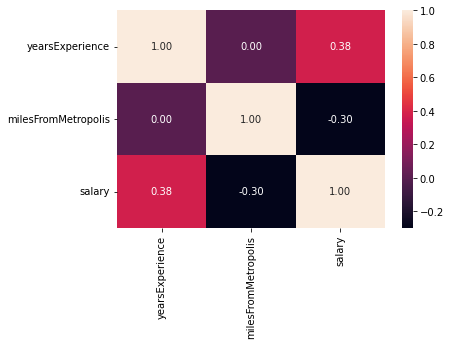

In [27]:
sns.heatmap(data=corr, annot=True, fmt=".2f")

*Obvservation*
- `yearsExperience` and `salary` are positively correlated.
- `yearsExperience` and `milesFromMetropolis` have no correlation.
- `milesFromMetropolis` and `salary` are weakly negatively correlated.

## Chi-Square test

In [28]:
def perform_chi_square_test(var_1, var_2):

    cross = pd.crosstab(index=final_train_df[var_1], columns=final_train_df[var_2])

    # Contingency Table
    (chi2, p, dof, _) = chi2_contingency(
        [cross.iloc[i].values for i in range(len(cross))]
    )

    print("Degree of Freedom: ", dof)

    # Significance Level 5%
    alpha = 0.05
    print("Significance level: ", alpha)

    # chi-square statistic
    print("chi-square statistic: ", chi2)

    # p-value
    print("p-value:", p)

    if p <= alpha:
        print("Reject H0, There is a relationship between 2 categorical variables")
    else:
        print("Retain H0, There is no relationship between 2 categorical variables")

In [29]:
for (col1, col2) in list(combinations(cat_cols, 2)):
    print(f"Chi-Squared test for {col1} & {col2}")
    print("-" * 70)
    perform_chi_square_test(col1, col2)
    print("*" * 70)
    print()

Chi-Squared test for jobType & degree
----------------------------------------------------------------------
Degree of Freedom:  28
Significance level:  0.05
chi-square statistic:  158620.81447095104
p-value: 0.0
Reject H0, There is a relationship between 2 categorical variables
**********************************************************************

Chi-Squared test for jobType & major
----------------------------------------------------------------------
Degree of Freedom:  56
Significance level:  0.05
chi-square statistic:  125514.70618848808
p-value: 0.0
Reject H0, There is a relationship between 2 categorical variables
**********************************************************************

Chi-Squared test for jobType & industry
----------------------------------------------------------------------
Degree of Freedom:  42
Significance level:  0.05
chi-square statistic:  47.265180908558605
p-value: 0.2662543916255588
Retain H0, There is no relationship between 2 categorical variables

*Obvservation*

- Following are correlated:
    - `jobtype` and `degree`
    - `jobtype` and `major`
    - `degree` and `major`

## Visualization

### Box-plot

****************************************
From BOX-PLOT we can infer the following
****************************************


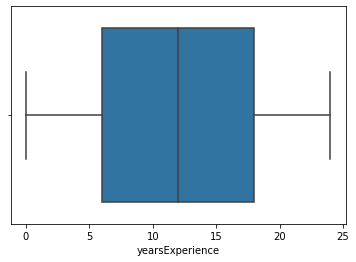

Column: yearsExperience
--------------------
Mean => 11.992
25% values are less than => 6.0
75% values are less than => 18.0
Inter-Quartile-Range => 12.0


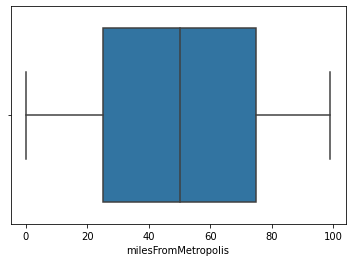

Column: milesFromMetropolis
--------------------
Mean => 49.529
25% values are less than => 25.0
75% values are less than => 75.0
Inter-Quartile-Range => 50.0


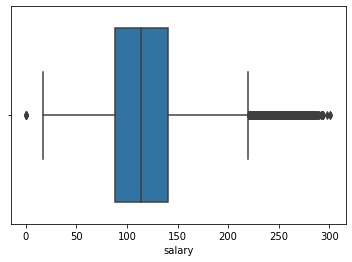

Column: salary
--------------------
Mean => 116.062
25% values are less than => 88.0
75% values are less than => 141.0
Inter-Quartile-Range => 53.0


In [30]:
print("*" * 40)
print("From BOX-PLOT we can infer the following")
print("*" * 40)

for col in num_cols:
    _ = sns.boxplot(data=final_train_df, x=col)
    plt.show()
    q1 = final_train_df[col].quantile(0.25)
    q2 = final_train_df[col].quantile(0.75)
    iqr = q2 - q1
    print(("=" * 40))
    print(f"Column: {col}")
    print(("-" * 20))
    print(f"Mean => {round(final_train_df[col].mean(), 3)}")
    print(f"25% values are less than => {round(q1, 3)}")
    print(f"75% values are less than => {round(q2, 3)}")
    print(f"Inter-Quartile-Range => {round(iqr, 3)}")
    print(("=" * 40))

### Histogram

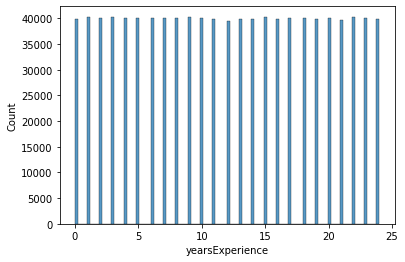

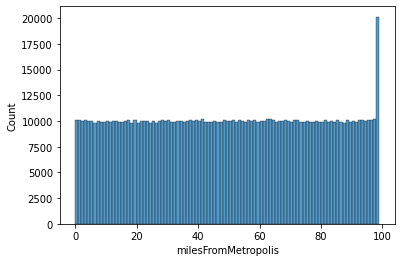

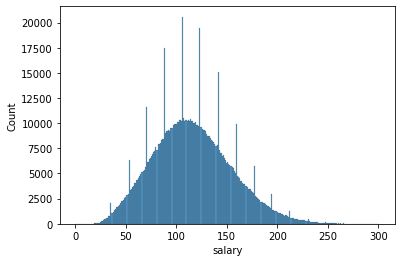

In [31]:
for col in num_cols:
    _ = sns.histplot(data=final_train_df, x=col)
    plt.show()

*Obvservation*
- `yearsOfExperience` has a uniform distribution
- `milesFromMetropolis` has a uniform distribution
- `salary` follows a unimodal distibution

In [32]:
final_train_df.columns

Index(['jobType', 'degree', 'major', 'industry', 'yearsExperience',
       'milesFromMetropolis', 'salary'],
      dtype='object')

In [33]:
count_by_jobtype = final_train_df.groupby(by="jobType").count()

<AxesSubplot:xlabel='jobType'>

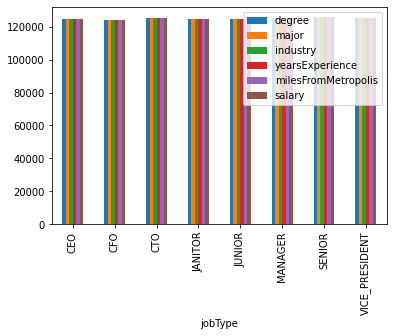

In [34]:
count_by_jobtype.plot.bar()

### Distribution grouped by column values

Grouped by: jobType


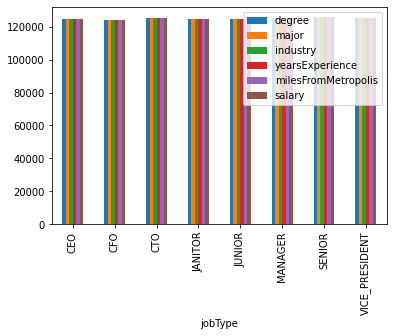

Grouped by: degree


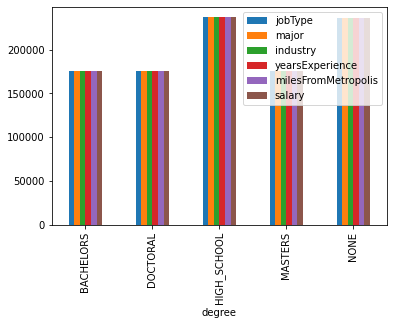

Grouped by: major


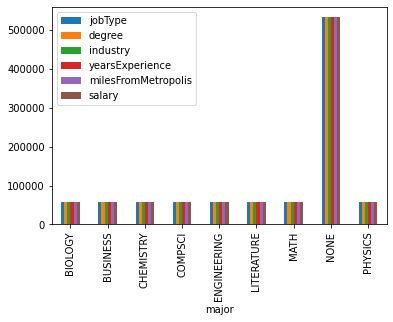

Grouped by: industry


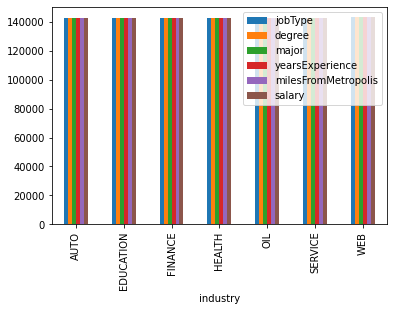

Grouped by: yearsExperience


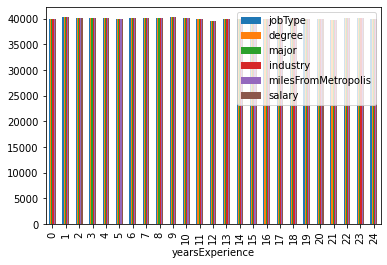

Grouped by: milesFromMetropolis


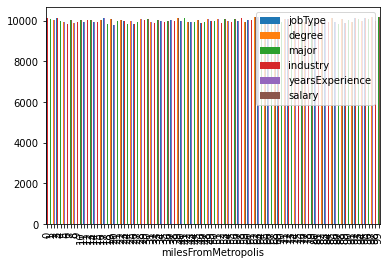

Grouped by: salary


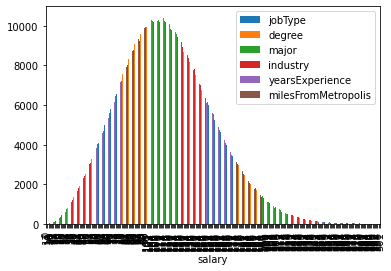

In [35]:
for col in final_train_df.columns:
    print("="*50)
    print(f"Grouped by: {col}")
    grouped_count = final_train_df.groupby(by=col).count()
    grouped_count.plot.bar()
    plt.show()
    print("="*50)

*obvservation*

- `salary` column has a symmetrical distribution
- Columns `jobType`, `industry`, `yearsExprience` have a uniform distribution.
- For `degree` column:
    - All data for BACHELORS, DOCTORAL, MASTERS are equally distributed.
    - All data for HIGH_SCHOOL, NONE are equally distributed.
    - Here the data distribution between group of BACHELORS, DOCTORAL, MASTERS is less than data distribution for group HIGH_SCHOOL, NONE
- For `major` column: 
    - Except "NONE" all data for each major are equally distributed.
    - There is large distribution of data for major NONE as compared to other major's

## Feature Selection

### Variance Inflation Factor

In [36]:
final_train_df[num_cols].head()

,yearsExperience,milesFromMetropolis,salary
0,10,83,130
1,3,73,101
2,10,38,137
3,8,17,142
4,8,16,163


In [37]:
# Calculating the VIF
for idx in range(0, len(num_cols) - 1):
    
    # `y` and `X`
    y = final_train_df.salary
    X = final_train_df[num_cols].drop(labels=["salary"], axis=1)
    
    # add constant term
    X_cons = sm.add_constant(X)
    
    # `OLS` model
    model = sm.OLS(endog=y, exog=X_cons)
    results = model.fit()
    
    print(f"R-squared value for column {num_cols[idx]}: {round(results.rsquared, 3)}")
    print(f"VIF of column {num_cols[idx]}: {round(variance_inflation_factor(X.values, idx), 3)}\n")

R-squared value for column yearsExperience: 0.229
VIF of column yearsExperience: 2.214

R-squared value for column milesFromMetropolis: 0.229
VIF of column milesFromMetropolis: 2.214



*Observations*

- There is colinearity/multicolinearity between variables as the VIF value is almost upto 2.5
- `yearsExperience` and `milesFromMetropolis` both have colinearity with all the variables.

In [62]:
def plot_probplot(df_, col_name, target):
    """
    This function plots probabilty plot for 
    unique values in a column against the `target`
    
    Parameters
    ----------
    
    df_: pd.Dataframe
        The Dataframe containing values
    
    col_name: str
        The column name to plot against the target
        
    target: str
        The target
    """
    
    # Unique values for a categorical column
    unq = df_[col_name].unique()
    
    print(df_[col_name].value_counts())
    
    # Iterating over each value
    # Probplot for current val v/s target
    for val in unq:
        
        # Target for current val
        y = df_[final_train_df[col_name] == val][target]
        
        # Show the probplot
        probplot(y, plot=plt)
        plt.title(f"Probabilty plot for {val}")
        plt.show()

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64


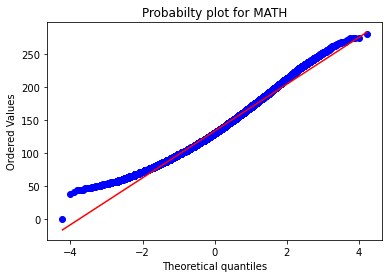

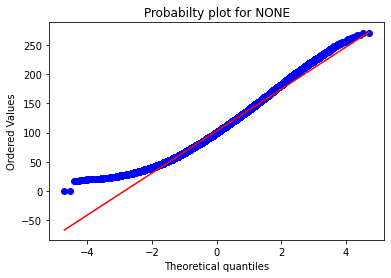

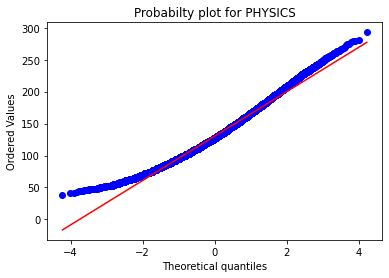

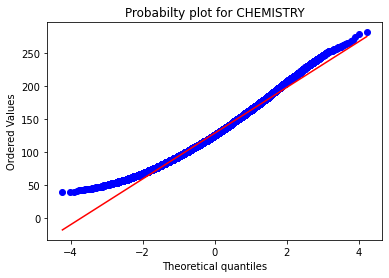

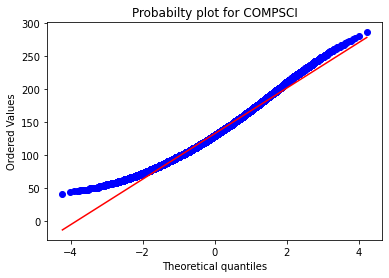

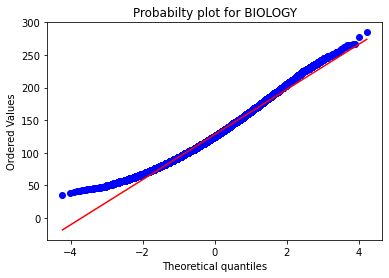

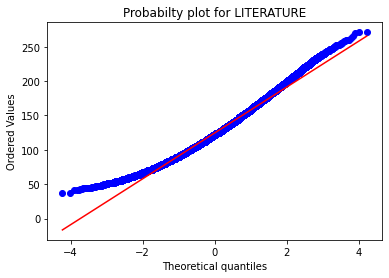

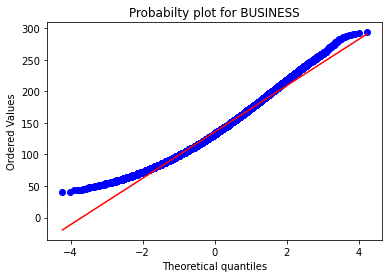

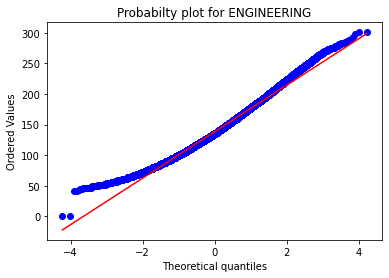

In [63]:
plot_probplot(final_train_df, "major", "salary")

In [64]:
final_train_df.to_csv("dataset/final.csv", index=False)